In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, create_info
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import AverageTFR

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [3]:
epochs = read_epochs('ica_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\ah\ica_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


Time Frequency Analysis

In [4]:
channels = ['FC5','FC3','C3','C5','CP3','CP5','P3']
conditions = ['left','right','rest']
tmin = -0.1
tmax = 2.

In [5]:
freqs = np.arange(7,120)
freq_bounds = {
    '_': 0,
    'delta': 3,
    'theta': 7,
    'alpha': 13,
    'beta' : 35,
    'l-gamma': 70,
    'm-gamma': 90,
    'h-gamma': 120
}


In [5]:
tfr = tfr_multitaper(epochs[conditions].copy().filter(1,120,n_jobs=8).pick(channels), freqs=freqs, n_cycles=freqs, n_jobs=8, use_fft=True,
        return_itc=False, average=False, decim=2)
tfr.apply_baseline((-1.4,-0.1), mode='percent')
tfr.crop(tmin,tmax)

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 152 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 2172 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 2304 out of 2304 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:   21.7s remaining:   54.4s
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:   22.5s remaining:   16.8s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   23.6s finished


Not setting metadata
Applying baseline correction (mode: percent)


<EpochsTFR | time : [-0.099609, 2.000000], freq : [7.000000, 119.000000], epochs : 36, channels : 7, ~233.8 MB>

In [135]:
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()), labels=list(freq_bounds)[1:])

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [136]:
df = df[df.band.isin(['beta','l-gamma','m-gamma'])]
df['band'] = df['band'].cat.remove_unused_categories()
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set(xlim=(tmin, tmax))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Binary CSP + LDA classification

In [4]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
# compute_rank(subset)

In [99]:
min_freq = 7.
max_freq = 140.
tmin = 0
tmax = 0.8
n_freqs = 10  # how many frequency bins to use
components = 5
classes = list(subset.event_id.keys())

In [85]:
csp = CSP(n_components=components, reg=None, log=True, norm_trace=False, rank='info')
clf = make_pipeline(csp, LinearDiscriminantAnalysis())
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=34)
le = LabelEncoder()

In [50]:
freqs = [2.,7.,18.,30.,40.,60.,70.,90.,100.,110.,120.]
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
freq_labels = []
freq_scores = []

In [7]:
subset = subset.apply_baseline((-1.3,-0.3))
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [52]:
for freq, (fmin, fmax) in enumerate(freq_ranges):
    test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4) 
    test.drop_channels(test.info['bads'])
    
    if tmin > 3 and (conditions[1] == 'rest'):
        rest = subset['rest'].copy().crop(0, tmax-tmin).filter(fmin, fmax, n_jobs=4)
        rest.drop_channels(rest.info['bads'])
        X = np.concatenate([test[condtion[0]].get_data(), rest.get_data()])
    else:
        X = test.get_data()
    
    chance = np.mean(y == y[0])
    chance = max(chance, 1. - chance)
        
    freq_labels.append(str(int(fmax)))
    freq_scores.append(
        cross_val_score(
            estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv, n_jobs=8))
    
    print(freq_labels)
    print('SCORE '+str(np.mean(freq_scores)))

Setting up band-pass filter from 2 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 1691 samples (1.651 sec)



C:\Users\at18157\AppData\Local\Temp\ipykernel_1632\965692713.py:2: RuntimeWarning: filter_length (1691) is longer than the signal (820), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.2s finished


['7']
SCORE nan
Setting up band-pass filter from 7 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 1691 samples (1.651 sec)



C:\Users\at18157\AppData\Local\Temp\ipykernel_1632\965692713.py:2: RuntimeWarning: filter_length (1691) is longer than the signal (820), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.1s finished


['7', '18']
SCORE nan
Setting up band-pass filter from 18 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 751 samples (0.733 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1216 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.1s finished


['7', '18', '30']
SCORE nan
Setting up band-pass filter from 30 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 451 samples (0.440 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.0s finished


['7', '18', '30', '40']
SCORE nan
Setting up band-pass filter from 40 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 339 samples (0.331 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1256 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    1.9s finished


['7', '18', '30', '40', '60']
SCORE nan
Setting up band-pass filter from 60 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 227 samples (0.222 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.0s finished


['7', '18', '30', '40', '60', '70']
SCORE nan
Setting up band-pass filter from 70 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.00
- Lower transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 195 samples (0.190 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    1.9s finished


['7', '18', '30', '40', '60', '70', '90']
SCORE nan
Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 151 samples (0.147 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.0s finished


['7', '18', '30', '40', '60', '70', '90', '100']
SCORE nan
Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 137 samples (0.134 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    2.1s finished


['7', '18', '30', '40', '60', '70', '90', '100', '110']
SCORE nan
Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 123 samples (0.120 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1256 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1485 out of 1485 | elapsed:    1.9s finished


['7', '18', '30', '40', '60', '70', '90', '100', '110', '120']
SCORE nan


In [53]:
scores_df = pd.DataFrame(data=np.transpose(freq_scores), columns=[freq_labels])

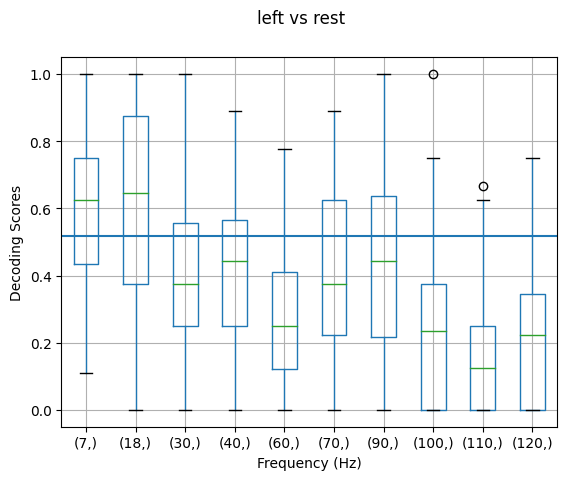

In [54]:
csp_fig, axes = plt.subplots(1)
scores_df.boxplot(ax=axes)
axes.axhline(chance)
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Decoding Scores')
csp_fig.suptitle(classes[0]+' vs '+classes[1])
plt.show()

In [55]:
score_median = []
scores_df = scores_df.dropna()
for col in scores_df.columns:
    score_median.append(np.median(scores_df[col]))

In [56]:
score_median

[0.625,
 0.6458333333333333,
 0.375,
 0.4444444444444445,
 0.25,
 0.375,
 0.4444444444444444,
 0.2361111111111111,
 0.125,
 0.22222222222222224]

In [33]:
del subset

In [128]:
tmin, tmax = -.500, 1.5
n_cycles = 35.
n_frqs = 22

freqs = np.linspace(min_freq, max_freq, n_frqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

window_spacing = (n_cycles / np.max(freqs /2))
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)


In [129]:
centered_w_times

array([0. , 0.5, 1. ])

In [130]:
window_spacing

0.5

In [131]:
centered_w_times

array([0. , 0.5, 1. ])

In [132]:
tf_scores = np.zeros((n_frqs - 1, n_windows))
i = 0
for freq, (fmin, fmax) in enumerate(freq_ranges):
    w_size = n_cycles / ((fmax + fmin) / 2.) 
    
    test = subset.copy().filter(fmin, fmax, n_jobs=8) 
    test.drop_channels(test.info['bads'])
    i += 1
    print(i)
    for t, w_time in enumerate(centered_w_times):
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.
        print(w_tmin, w_tmax)
        
        X = test.copy().crop(w_tmin, w_tmax).get_data()
    
        tf_scores[freq, t] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv, n_jobs=8))

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.33 Hz
- Upper transition bandwidth: 3.33 Hz (-6 dB cutoff frequency: 15.00 Hz)
- Filter length: 1691 samples (1.651 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    4.4s finished


1
-1.7213114754098362 1.7213114754098362
-1.2213114754098362 2.221311475409836
-0.7213114754098362 2.721311475409836
Setting up band-pass filter from 13 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.33
- Lower transition bandwidth: 3.33 Hz (-6 dB cutoff frequency: 11.67 Hz)
- Upper passband edge: 19.67 Hz
- Upper transition bandwidth: 4.92 Hz (-6 dB cutoff frequency: 22.12 Hz)
- Filter length: 1015 samples (0.991 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.9s finished


2
-1.0606060606060606 1.0606060606060606
-0.5606060606060606 1.5606060606060606
-0.06060606060606055 2.0606060606060606
Setting up band-pass filter from 20 - 26 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 19.67
- Lower transition bandwidth: 4.92 Hz (-6 dB cutoff frequency: 17.21 Hz)
- Upper passband edge: 26.00 Hz
- Upper transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 29.25 Hz)
- Filter length: 689 samples (0.673 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.8s finished


3
-0.7664233576642336 0.7664233576642336
-0.26642335766423364 1.2664233576642336
0.23357664233576636 1.7664233576642336
Setting up band-pass filter from 26 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 26.00
- Lower transition bandwidth: 6.50 Hz (-6 dB cutoff frequency: 22.75 Hz)
- Upper passband edge: 32.33 Hz
- Upper transition bandwidth: 8.08 Hz (-6 dB cutoff frequency: 36.37 Hz)
- Filter length: 521 samples (0.509 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 1410 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


4
-0.6000000000000001 0.6000000000000001
-0.10000000000000009 1.1
0.3999999999999999 1.6
Setting up band-pass filter from 32 - 39 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 32.33
- Lower transition bandwidth: 8.08 Hz (-6 dB cutoff frequency: 28.29 Hz)
- Upper passband edge: 38.67 Hz
- Upper transition bandwidth: 9.67 Hz (-6 dB cutoff frequency: 43.50 Hz)
- Filter length: 419 samples (0.409 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.8s finished


5
-0.49295774647887325 0.49295774647887325
0.007042253521126751 0.9929577464788732
0.5070422535211268 1.4929577464788732
Setting up band-pass filter from 39 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 38.67
- Lower transition bandwidth: 9.67 Hz (-6 dB cutoff frequency: 33.83 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 351 samples (0.343 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


6
-0.4183266932270917 0.4183266932270917
0.0816733067729083 0.9183266932270917
0.5816733067729083 1.4183266932270917
Setting up band-pass filter from 45 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 45.00
- Lower transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Upper passband edge: 51.33 Hz
- Upper transition bandwidth: 12.83 Hz (-6 dB cutoff frequency: 57.75 Hz)
- Filter length: 301 samples (0.294 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.8s finished


7
-0.3633217993079585 0.3633217993079585
0.1366782006920415 0.8633217993079585
0.6366782006920415 1.3633217993079585
Setting up band-pass filter from 51 - 58 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 51.33
- Lower transition bandwidth: 12.83 Hz (-6 dB cutoff frequency: 44.92 Hz)
- Upper passband edge: 57.67 Hz
- Upper transition bandwidth: 14.42 Hz (-6 dB cutoff frequency: 64.88 Hz)
- Filter length: 265 samples (0.259 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


8
-0.3211009174311927 0.3211009174311927
0.17889908256880732 0.8211009174311927
0.6788990825688073 1.3211009174311927
Setting up band-pass filter from 58 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 57.67
- Lower transition bandwidth: 14.42 Hz (-6 dB cutoff frequency: 50.46 Hz)
- Upper passband edge: 64.00 Hz
- Upper transition bandwidth: 16.00 Hz (-6 dB cutoff frequency: 72.00 Hz)
- Filter length: 235 samples (0.229 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 1410 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


9
-0.28767123287671237 0.28767123287671237
0.21232876712328763 0.7876712328767124
0.7123287671232876 1.2876712328767124
Setting up band-pass filter from 64 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 64.00
- Lower transition bandwidth: 16.00 Hz (-6 dB cutoff frequency: 56.00 Hz)
- Upper passband edge: 70.33 Hz
- Upper transition bandwidth: 17.58 Hz (-6 dB cutoff frequency: 79.12 Hz)
- Filter length: 213 samples (0.208 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


10
-0.26054590570719605 0.26054590570719605
0.23945409429280395 0.760545905707196
0.739454094292804 1.260545905707196
Setting up band-pass filter from 70 - 77 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.33
- Lower transition bandwidth: 17.58 Hz (-6 dB cutoff frequency: 61.54 Hz)
- Upper passband edge: 76.67 Hz
- Upper transition bandwidth: 19.17 Hz (-6 dB cutoff frequency: 86.25 Hz)
- Filter length: 193 samples (0.188 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


11
-0.23809523809523808 0.23809523809523808
0.2619047619047619 0.7380952380952381
0.7619047619047619 1.2380952380952381
Setting up band-pass filter from 77 - 83 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 76.67
- Lower transition bandwidth: 19.17 Hz (-6 dB cutoff frequency: 67.08 Hz)
- Upper passband edge: 83.00 Hz
- Upper transition bandwidth: 20.75 Hz (-6 dB cutoff frequency: 93.38 Hz)
- Filter length: 177 samples (0.173 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


12
-0.21920668058455117 0.21920668058455117
0.2807933194154488 0.7192066805845512
0.7807933194154488 1.2192066805845512
Setting up band-pass filter from 83 - 89 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 83.00
- Lower transition bandwidth: 20.75 Hz (-6 dB cutoff frequency: 72.62 Hz)
- Upper passband edge: 89.33 Hz
- Upper transition bandwidth: 22.33 Hz (-6 dB cutoff frequency: 100.50 Hz)
- Filter length: 163 samples (0.159 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


13
-0.2030947775628627 0.2030947775628627
0.2969052224371373 0.7030947775628626
0.7969052224371374 1.2030947775628626
Setting up band-pass filter from 89 - 96 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 89.33
- Lower transition bandwidth: 22.33 Hz (-6 dB cutoff frequency: 78.17 Hz)
- Upper passband edge: 95.67 Hz
- Upper transition bandwidth: 23.92 Hz (-6 dB cutoff frequency: 107.62 Hz)
- Filter length: 153 samples (0.149 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.8s finished


14
-0.1891891891891892 0.1891891891891892
0.3108108108108108 0.6891891891891893
0.8108108108108107 1.1891891891891893
Setting up band-pass filter from 96 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 95.67
- Lower transition bandwidth: 23.92 Hz (-6 dB cutoff frequency: 83.71 Hz)
- Upper passband edge: 102.00 Hz
- Upper transition bandwidth: 25.50 Hz (-6 dB cutoff frequency: 114.75 Hz)
- Filter length: 143 samples (0.140 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


15
-0.17706576728499157 0.17706576728499157
0.32293423271500843 0.6770657672849916
0.8229342327150084 1.1770657672849916
Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 102.00
- Lower transition bandwidth: 25.50 Hz (-6 dB cutoff frequency: 89.25 Hz)
- Upper passband edge: 108.33 Hz
- Upper transition bandwidth: 27.08 Hz (-6 dB cutoff frequency: 121.88 Hz)
- Filter length: 133 samples (0.130 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


16
-0.16640253565768623 0.16640253565768623
0.33359746434231374 0.6664025356576863
0.8335974643423137 1.1664025356576861
Setting up band-pass filter from 1.1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 108.33
- Lower transition bandwidth: 27.08 Hz (-6 dB cutoff frequency: 94.79 Hz)
- Upper passband edge: 114.67 Hz
- Upper transition bandwidth: 28.67 Hz (-6 dB cutoff frequency: 129.00 Hz)
- Filter length: 125 samples (0.122 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 167 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1378 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


17
-0.15695067264573992 0.15695067264573992
0.3430493273542601 0.6569506726457399
0.8430493273542601 1.15695067264574
Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 114.67
- Lower transition bandwidth: 28.67 Hz (-6 dB cutoff frequency: 100.33 Hz)
- Upper passband edge: 121.00 Hz
- Upper transition bandwidth: 30.25 Hz (-6 dB cutoff frequency: 136.12 Hz)
- Filter length: 119 samples (0.116 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1410 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.6s finished


18
-0.1485148514851485 0.1485148514851485
0.35148514851485146 0.6485148514851485
0.8514851485148515 1.1485148514851484
Setting up band-pass filter from 1.2e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 121.00
- Lower transition bandwidth: 30.25 Hz (-6 dB cutoff frequency: 105.88 Hz)
- Upper passband edge: 127.33 Hz
- Upper transition bandwidth: 31.83 Hz (-6 dB cutoff frequency: 143.25 Hz)
- Filter length: 113 samples (0.110 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.7s finished


19
-0.14093959731543626 0.14093959731543626
0.35906040268456374 0.6409395973154363
0.8590604026845637 1.1409395973154361
Setting up band-pass filter from 1.3e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 127.33
- Lower transition bandwidth: 31.83 Hz (-6 dB cutoff frequency: 111.42 Hz)
- Upper passband edge: 133.67 Hz
- Upper transition bandwidth: 33.42 Hz (-6 dB cutoff frequency: 150.38 Hz)
- Filter length: 107 samples (0.104 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1410 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    4.0s finished


20
-0.13409961685823754 0.13409961685823754
0.36590038314176243 0.6340996168582376
0.8659003831417624 1.1340996168582376
Setting up band-pass filter from 1.3e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 133.67
- Lower transition bandwidth: 33.42 Hz (-6 dB cutoff frequency: 116.96 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 103 samples (0.101 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 1410 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 1485 out of 1485 | elapsed:    3.8s finished


21
-0.12789281364190014 0.12789281364190014
0.37210718635809986 0.6278928136419002
0.8721071863580998 1.1278928136419002


In [133]:
av_tfr = AverageTFR(create_info(['sfreq'],subset.info['sfreq']), tf_scores[np.newaxis,:],
                   centered_w_times, freqs[1:],1)

No baseline correction applied


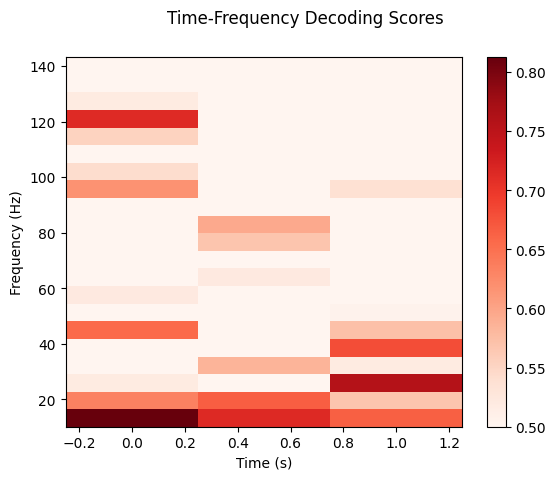

[<Figure size 640x480 with 2 Axes>]

In [134]:
av_tfr.plot([0], vmin=0.5, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)

No baseline correction applied


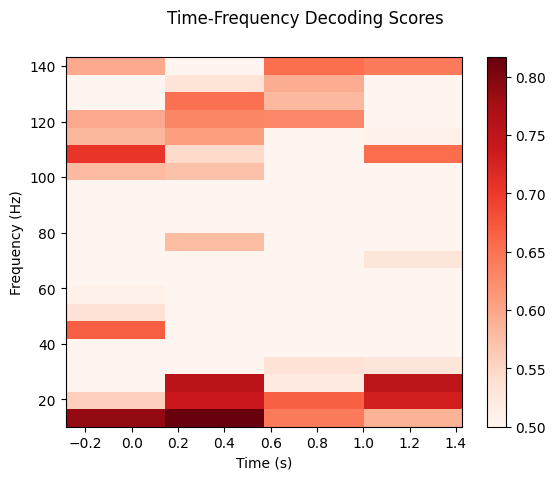

[<Figure size 640x480 with 2 Axes>]

In [117]:
av_tfr.plot([0], vmin=0.5, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)

No baseline correction applied


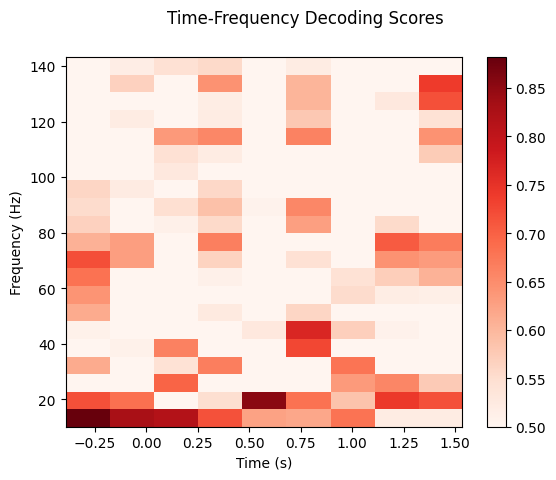

[<Figure size 640x480 with 2 Axes>]

In [106]:
av_tfr.plot([0], vmin=0.5, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)